# <center>Abalone Classification & Prediction Analysis</center>
<img src="files/abalone_pic2.jpg">
Summary Analysis
---------------------
The classification of young, medium, and old Abalone's holds limited predictive capacity for the given dataset.  This analysis includes Decision Trees, Support Vector Machines, KNearest Neighbors, and XGBoost models.  All models are the 61-66% accuracy range with the SVM algorithm holding the top spot. Additional models, PCA, more samples and more features could provide more predictive power.  Below is is an overview of the models and their accuracy:

In [102]:
py.iplot(fig, filename='horizontal-bar')

Model Overview
==============

### Decision Trees
> This is my base model to get a sense of the predictive capability of the dataset and an idea of feature importance.  As you can see below, Whole_weight is highly significant important when classifying.     

### SVM
>SVM is an excellent algorithm for classification with complete data.  RBF and polynomial kernals could be especially beneficial given the data's smallish sample size. 


### KNearestNeighbors
>A slightly different clustering approach than SVM, KNN may be beneficial given the low dimensionality of the data. KNN tends to be more computationally expensive but worth the comparison on this small sample set.   

### XGBoost
>This GBM model has a few advantages including regularization, cross-validation at each iteration, and is less greedy than regular GBM. I used accuracy for CV, multi:softmax for the objective, and scaled data similar to SVM even though it isn't necessary.  I followed a sequential tuning pattern starting the adjustment in max_depth, min_child_weight, and gamma.  Those tend to have the greatest impact.  I then focused the learning_rate which is a very effective tuning parameter but also highly susceptible to overfitting the model. I used a simpled cross_val function and grid search to finalizet the XGB model.  Results were on par with kNN and SVM.  

## What's Next?

Several additional models such as Random Forest, GBM, AdaBoost, KMeans, ExtraTrees, and other Hierarchical clustering models could improve the score.  The models I chose have a good representation of the model 'genres' and additional models will very likely have similar results.  The data does have correlations and could benefit from PCA.  It's so small that for this breif analysis, I skipped that portion.  Outside of several feature engineering tricks, I could look at ensembling various models to optimize results.  Lastly, my generic model testing definition could be improved for renemed stratified sampling, model comparison, etc.  

The models can improve; however, additional data and features would provide the most significant effect in improving predictive capacity. 

## The Data

> The data is complete and small. Most features are skewed with non-linear correlations, as you can see from the pairplot below. Regularization will be needed, depending on the model. Irregardless, I scaled the data to improve SVM but it isn't necessary for the other models.  I kept it in there because regularized data don't hurt the results for these models.  

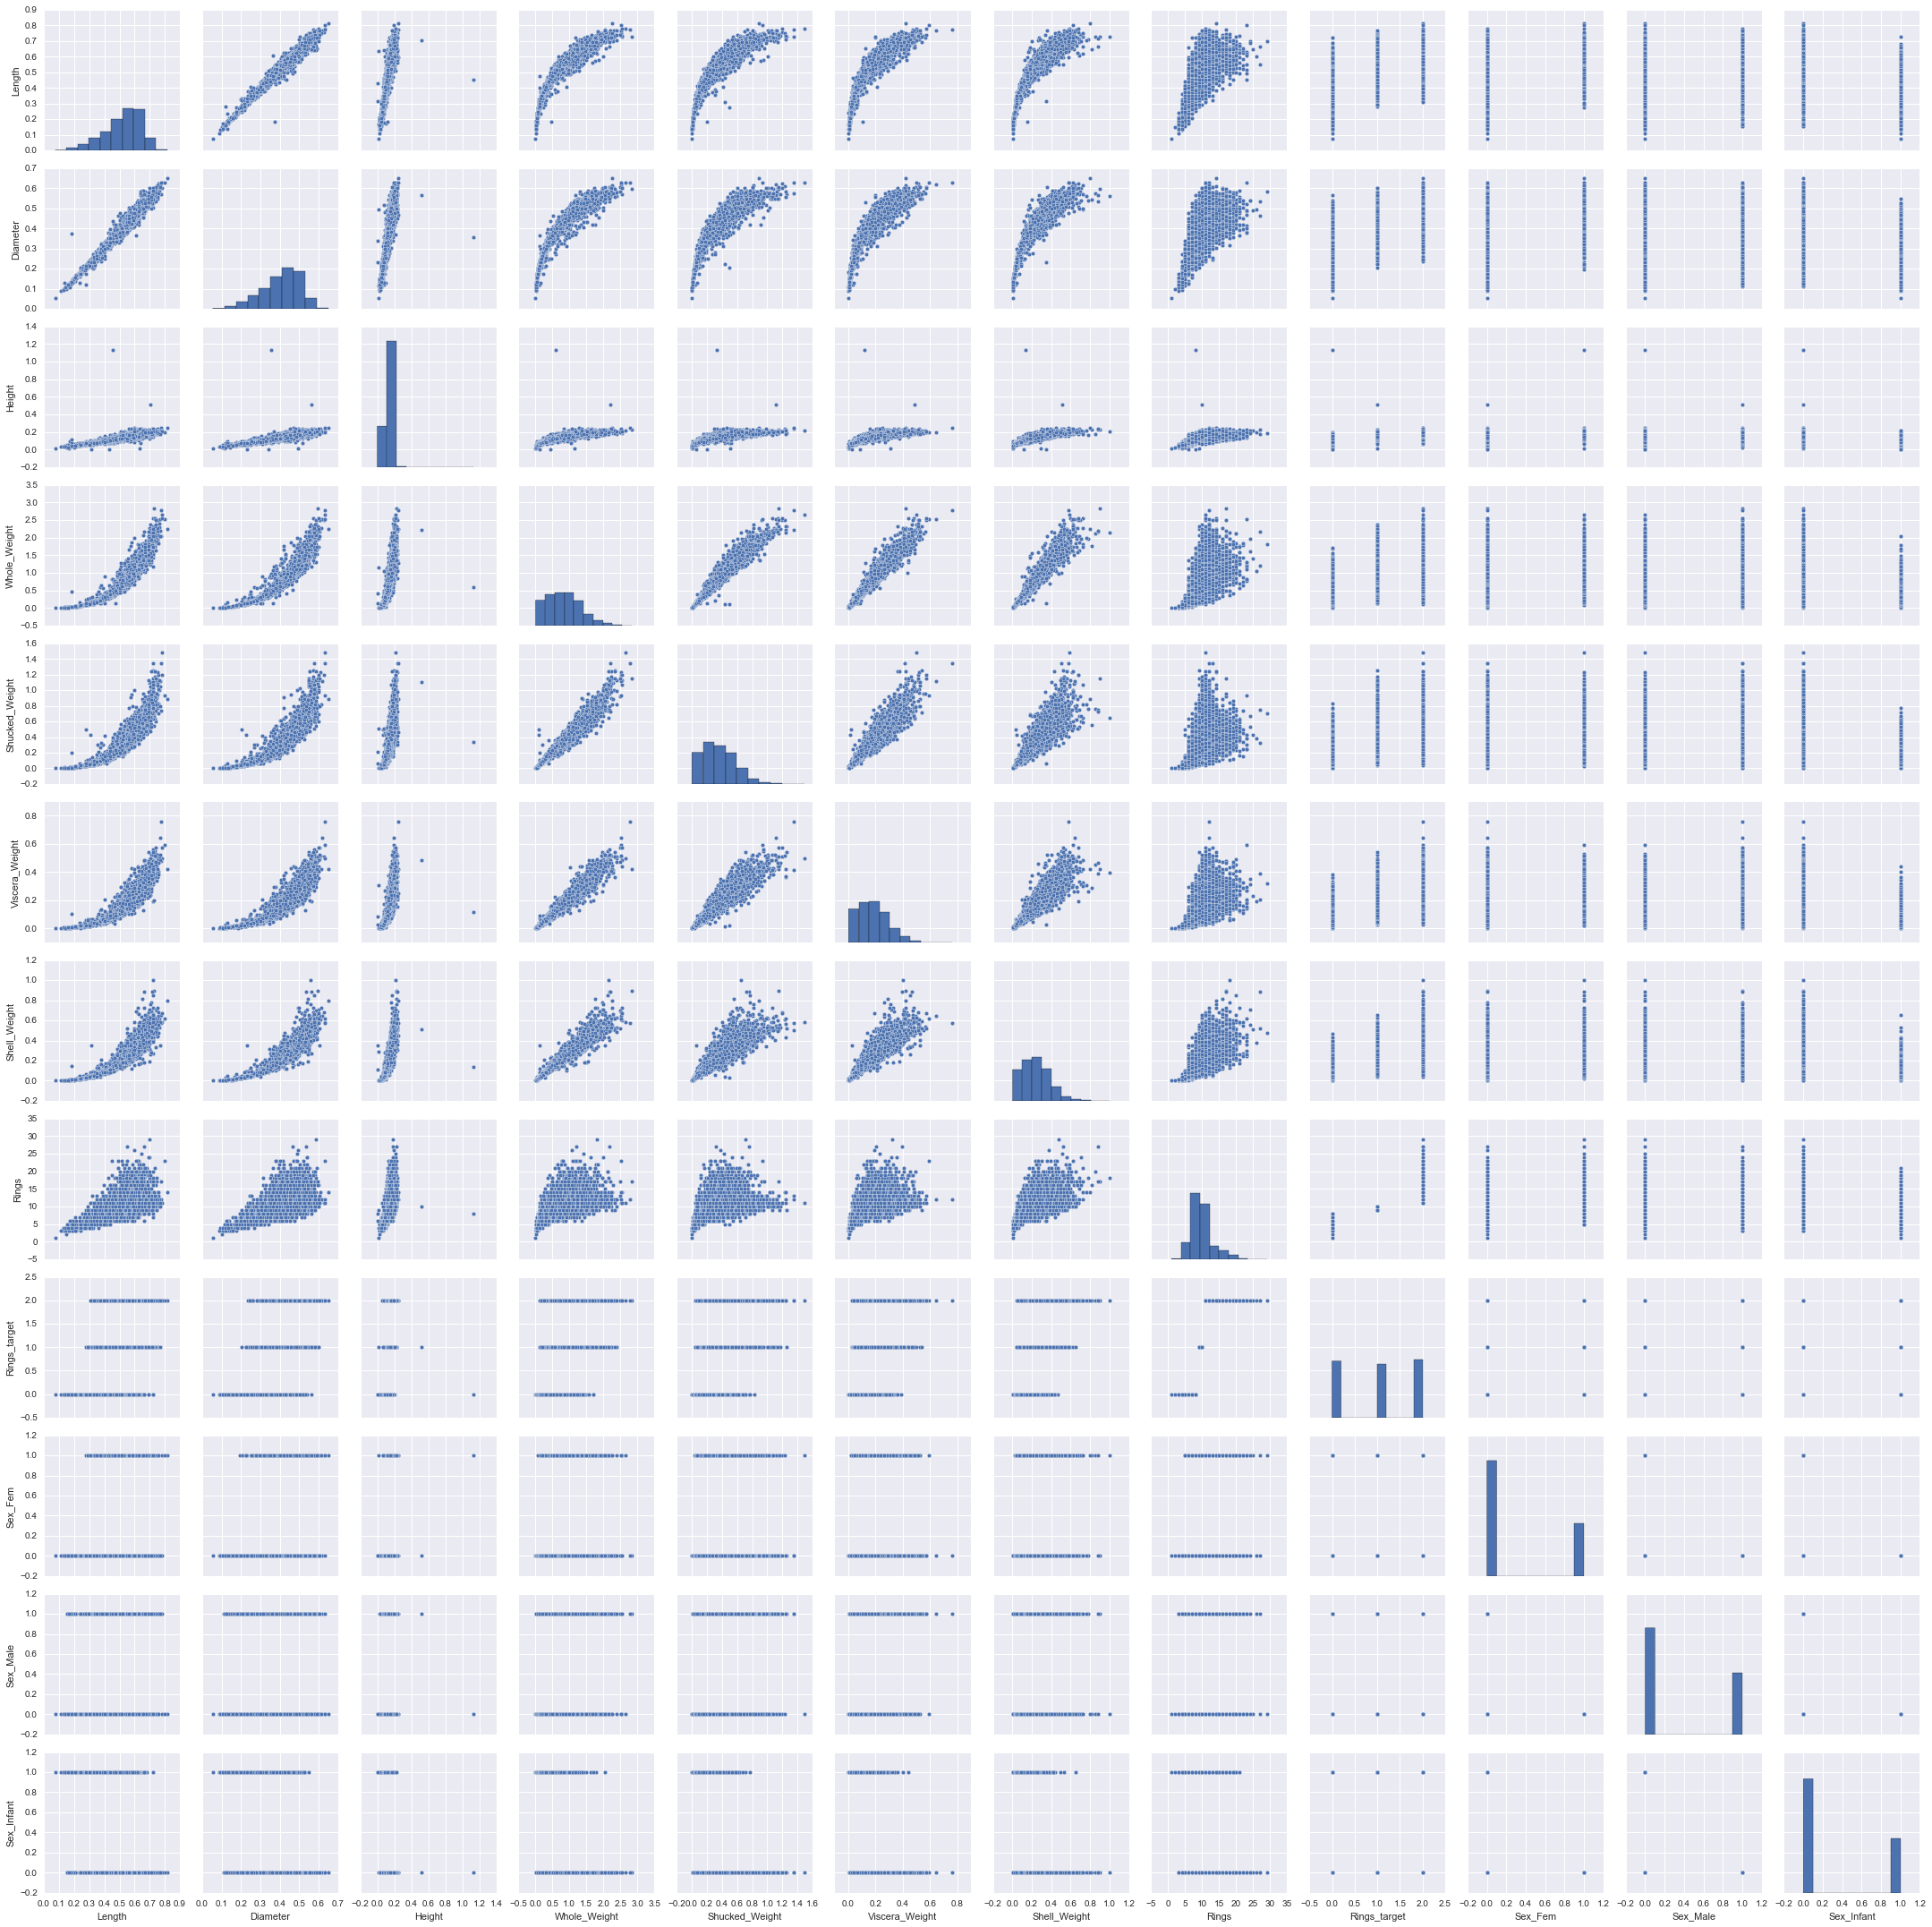

In [8]:
%matplotlib inline
sns.pairplot(df)

## Feature Importance Chart

In [70]:
py.iplot(data, filename='basic-bar')

## Exploratory & Prep Analysis

In [2]:
# Load Dataa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None, 
                 names = ['Sex','Length','Diameter','Height','Whole_Weight','Shucked_Weight','Viscera_Weight','Shell_Weight','Rings'])

#create Rings classification of 'young','medium','old'. 1-8, 9-10, 11+ and break out Sex into F,M dummy variables (no infant)   
df.loc[df.Rings >= 11, 'Rings_class'] = 'old'
df.loc[df.Rings <= 8, 'Rings_class'] = 'young'
df.loc[(df.Rings == 9) | (df.Rings == 10), 'Rings_class'] = 'medium'

df['Rings_target'] = df['Rings_class'].map({'young': 0, 'medium': 1, 'old': 2})
df['Sex_Fem'] = df['Sex'].map({'F': 1, 'M': 0, 'I': 0})
df['Sex_Male'] = df['Sex'].map({'F': 0, 'M': 1, 'I': 0})
df['Sex_Infant'] = df['Sex'].map({'F': 0, 'M': 0, 'I': 1})

## Data Manipulation and Model Setup

In [3]:
# Split, Scale, Combine, Repackage......
# I included the Sex_Infant variable for the pairplot but it isn't needed for modeling--that's alread covered by Sex_Fem and Sex_Male

import sklearn
from sklearn import preprocessing
from sklearn import cross_validation

df_x = df.drop(['Sex','Rings_class','Rings', 'Rings_target','Sex_Fem','Sex_Male', 'Sex_Infant'], axis = 1)
df_scale = preprocessing.scale(df_x)

fem = np.array(df['Sex_Fem']).reshape(4177,1)
male= np.array(df['Sex_Male']).reshape(4177,1)
df_train = np.concatenate((df_scale, fem, male), axis=1)
y = df['Rings_target']

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(df_train, y, test_size=0.25,
                                                                             random_state=0, stratify = y)

df_scaled = pd.DataFrame({'Length': df_scale[:,0],'Diameter': df_scale[:,1],'Height': df_scale[:,2],'Whole_Weight': df_scale[:,3],
                          'Shucked_Weight': df_scale[:,4],'Viscera_Weight': df_scale[:,5],'Shell_Weight': df_scale[:,6]})

X_scaled = pd.concat([df_scaled, df[['Sex_Fem','Sex_Male']]], axis=1)
X_scaled.head(5)

,Diameter,Height,Length,Shell_Weight,Shucked_Weight,Viscera_Weight,Whole_Weight,Sex_Fem,Sex_Male
0,-0.432149,-1.064424,-0.574558,-0.638217,-0.607685,-0.726212,-0.641898,0,1
1,-1.439929,-1.183978,-1.448986,-1.212987,-1.170910,-1.205221,-1.230277,0,1
2,0.122130,-0.107991,0.050033,-0.207139,-0.463500,-0.356690,-0.309469,1,0
3,-0.432149,-0.347099,-0.699476,-0.602294,-0.648238,-0.607600,-0.637819,0,1
4,-1.540707,-1.423087,-1.615544,-1.320757,-1.215968,-1.287337,-1.272086,0,0


## Cross Validation Definition

In [7]:
import sklearn.metrics as metrics
import time

def evaluate_model(clf):
    """Scores a model using log loss with the created train and test sets."""
    start = time.time()
    clf.fit(X_train, y_train)
    print "Train score:", sklearn.metrics.accuracy_score(y_train, clf.predict(X_train))
    print "Test score:", sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))
    print "Total time:", time.time() - start
    
print "Training: " + str(X_train.shape) + str(y_train.shape)
print "Test: " + str(X_test.shape) + str(y_test.shape)

Training: (3132, 9)(3132,)
Test: (1045, 9)(1045,)


## Tree Model & Feature Importance

In [61]:
from sklearn import tree
import numpy as np
from sklearn.grid_search import GridSearchCV

params = [{"criterion": ["gini", "entropy"], "min_samples_leaf": range(7, 13), 
                   "min_samples_split": np.linspace(2, 30, 15), "max_depth": range(1,9)}]

grid = GridSearchCV(tree.DecisionTreeClassifier(), params, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)
evaluate_model(grid)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 5216 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   36.0s finished


Train score: 0.704342273308
Test score: 0.611483253589
Total time: 36.2301468849


In [62]:
from sklearn.grid_search import GridSearchCV
tree_accuracy = metrics.accuracy_score(y_test, grid.best_estimator_.predict(X_test))
print "Accuracy : %.4g" % tree_accuracy
print grid.best_params_
print grid.best_estimator_

Accuracy : 0.6115
{'min_samples_split': 16.0, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 8}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=8,
            min_samples_split=16.0, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [63]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=list(X_scaled.columns.values),
            y=grid.best_estimator_.feature_importances_
    )]

df_importance = pd.DataFrame({'Features': list(X_scaled.columns.values), 'Importance_values': grid.best_estimator_.feature_importances_})
print df_importance
#py.iplot(data, filename='basic-bar')

         Features  Importance_values
0        Diameter           0.020954
1          Height           0.013577
2          Length           0.068142
3    Shell_Weight           0.043432
4  Shucked_Weight           0.143929
5  Viscera_Weight           0.012053
6    Whole_Weight           0.647426
7         Sex_Fem           0.018914
8        Sex_Male           0.031575


## SVM Model

In [34]:
from sklearn import svm

params = [{'C': np.logspace(1, 3, 10), 'gamma': np.logspace(-5, 3, 10), 'kernel': ['rbf']},
          {'C': np.logspace(-3, 3, 10), 'kernel': ['poly'], 'degree': [1, 2, 3]}]

grid = GridSearchCV(svm.SVC(), params, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)
evaluate_model(grid)

svm_accuracy = metrics.accuracy_score(y_test, grid.best_estimator_.predict(X_test))
print "Accuracy : %.4g" % svm_accuracy
print grid.best_params_
print grid.best_estimator_
print grid.grid_scores_

Fitting 5 folds for each of 130 candidates, totalling 650 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:  3.6min finished


Train score: 0.69220945083
Test score: 0.662200956938
Total time: 220.214773178
Accuracy : 0.6622
{'kernel': 'rbf', 'C': 215.44346900318823, 'gamma': 0.035938136638046257}
SVC(C=215.44346900318823, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.035938136638046257,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
[mean: 0.55843, std: 0.01210, params: {'kernel': 'rbf', 'C': 10.0, 'gamma': 1.0000000000000001e-05}, mean: 0.58461, std: 0.01907, params: {'kernel': 'rbf', 'C': 10.0, 'gamma': 7.7426368268112782e-05}, mean: 0.62835, std: 0.01751, params: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.00059948425031894088}, mean: 0.65102, std: 0.00852, params: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.0046415888336127772}, mean: 0.66284, std: 0.01452, params: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.035938136638046257}, mean: 0.66284, std: 0.01314, params: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.

# Nearest Neighbors

In [18]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors':range(10,20), 'weights':['uniform', 'distance'], 'p': [1,2], 'leaf_size': range(1,15)}
grid = GridSearchCV(KNeighborsClassifier(), params, scoring='accuracy', n_jobs=-1)
evaluate_model(grid)

knn_accuracy = metrics.accuracy_score(y_test , grid.best_estimator_.predict(X_test))
print "Accuracy : %.4g" % knn_accuracy
print grid.best_params_
print grid.best_estimator_

#{'n_neighbors': 18, 'weights': 'uniform', 'leaf_size': 1, 'p': 2}

Train score: 0.687100893997
Test score: 0.643062200957
Total time: 3.61439585686
Accuracy : 0.6431
{'n_neighbors': 18, 'weights': 'uniform', 'leaf_size': 1, 'p': 2}
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


## XGBoost Model

In [104]:
# Part 1 of XGB: Setup base model and begin tuning max_depth, min_child_weight. 

from xgboost import XGBClassifier

params1 = {'max_depth': range(1,10), 'min_child_weight':range(1,10),
          'learning_rate': [.1],'n_estimators': [100], 
          'subsample': [.8], 'colsample_bytree': [.8],
          'nthread': [4], 'scale_pos_weight': [1],
          'gamma': [0], 'seed': [23]}

grid = GridSearchCV(XGBClassifier(objective = "multiclass:softmax", nthread=-1), param_grid = params1, cv = 5, verbose = 1)
evaluate_model(grid)

print grid.best_params_
print grid.best_estimator_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   15.9s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   20.8s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train score: 0.722541507024
Test score: 0.636363636364
Total time: 21.2464339733
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'nthread': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8, 'seed': 23, 'max_depth': 3, 'gamma': 0}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=100, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.8)


In [107]:
# After a few trial runs, I honed in on a range of hyperparameters

from xgboost import XGBClassifier

params3 = {'max_depth': range(3,5), 'min_child_weight':range(2,5),
          'learning_rate': [i/100.0 for i in range(15,30,5)],'n_estimators': [100], 
          'subsample': [i/10.0 for i in range(7,9)], 'colsample_bytree': [i/10.0 for i in range(5,8)],
          'nthread': [4], 'scale_pos_weight': [1],
          'gamma': [0,0.1], 'seed': [23]}

grid = GridSearchCV(XGBClassifier(objective = "multiclass:softmax", nthread=-1), n_jobs =-1, param_grid = params3, cv = 5, verbose = 1)
evaluate_model(grid)

xgb_accuracy = metrics.accuracy_score(y_test , grid.best_estimator_.predict(X_test))
print "Accuracy : %.4g" % xgb_accuracy
print grid.best_params_
print grid.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  2.4min finished


Train score: 0.742975734355
Test score: 0.644019138756
Total time: 141.61401701
Accuracy : 0.644
{'colsample_bytree': 0.7, 'scale_pos_weight': 1, 'learning_rate': 0.15, 'nthread': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.7, 'seed': 23, 'max_depth': 3, 'gamma': 0.1}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.1, learning_rate=0.15, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=100, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.7)


### Model Accuracy Plot

In [101]:
accuracy_plot = [go.Bar(
    y=['Decision Trees','SVM','KNN','XGBoost'],
    x=[tree_accuracy, svm_accuracy, knn_accuracy, xgb_accuracy],
    name='Model Accuracy',
    orientation = 'h',
    marker = dict(
        color = '#8FBC94'))]

layout = go.Layout(
    title='Model Accuracy',
    autosize=False,
    width=800,
    height=500,
    margin=go.Margin(
        l=200,
        r=20,
        pad=4
    ),
    xaxis=dict(
        title='Accuracy',
        range = [0.5,.8],
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='lightgrey'
        )),
    yaxis=dict(
        title='Model',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='lightgrey'
        ))
)

fig = go.Figure(data = accuracy_plot, layout = layout)